In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import random, vmap, jit
from jax.lax import scan

%config InlineBackend.figure_format='retina'

# Burgers D=1+1

IVP

\begin{equation}
  \begin{split}
    &\frac{\partial u(x, t)}{\partial t} = \nu \frac{\partial^2 u(x, t)} {\partial x^2} - \frac{1}{2}\frac{\partial \left(u(x, t)\right)^2}{\partial x},\\
    &u(x, 0) = u_{0}, u(1, t) = u(0, t),
  \end{split}
\end{equation}

where

\begin{equation}
    u_0 \sim \mathcal{N}\left(0, \left(I - c\Delta\right)^{-k}\right).
\end{equation}

In [2]:
def get_frequencies_and_weights(N, p, l):
    f = 2*jnp.pi*jnp.array([*range(N)])
    w = 1/(1 + (f/l)**2)**p
    return f, w

def random_init(x, key, f, w):
    c = random.normal(key, w.shape, dtype=jnp.complex64)
    return jnp.real(jnp.sum(jnp.exp(1j*f*x)*w*c))

def F(u, t, nu, freq):
    rhs = -1j*freq*jnp.fft.fft(jnp.real(jnp.fft.ifft(u))**2)/2 - nu*freq**2*u
    return rhs

def RK4(carry, t):
    u, nu, h, freq = carry
    a = F(u, t, nu, freq)
    b = F(u + a*h/2, t + h/2, nu, freq)
    c = F(u + b*h/2, t + h/2, nu, freq)
    d = F(u + c*h, t + h, nu, freq)
    u = u + h*(a + 2*b + 2*c + d)/6
    return [u, nu, h, freq], u

def generate_trajectory(u, nu, N_t, time):
    # the output of this functions are coefficients of Fourier series at timestemps given in the array named time
    # process the results appropriately
    # x \in [0, 1], t \in [0, 0.5]
    h = 0.5 / (N_t - 1)
    N = len(u)
    freq = 2*jnp.pi*jnp.fft.fftfreq(N) * N
    carry = [u, nu, h, freq]
    carry, history = scan(RK4, carry, time[1:])
    return jnp.vstack([u, history])

def get_dataset_Burgers_2D(N_spatial=100, N_time=10000, time_subsampling=100, N_samples=1000, nu=0.01, key=random.PRNGKey(22), p=2, l=20, N=50, normalize=False):
    f, w = get_frequencies_and_weights(N, p, l)
    random_initial_conditions = lambda x, key: vmap(random_init, in_axes=(0, None, None, None))(x, key, f, w)
    x = jnp.linspace(0, 1, N_spatial+1)[:-1]
    time = jnp.linspace(0, 0.5, N_time)
    features, targets = [], []
    for i in range(N_samples):
        key = random.split(key)[0]
        u = jnp.fft.fft(random_initial_conditions(x, key))
        history = jnp.transpose(generate_trajectory(u, nu, N_time, time)[::time_subsampling], [1, 0]) # [space, time]
        features.append(jnp.expand_dims(u, 0))
        targets.append(jnp.expand_dims(history, 0))
    features = jnp.stack(features, 0)
    targets = jnp.transpose(jnp.stack(targets, 0), (0, 1, 3, 2))
    X, T = jnp.meshgrid(x, time[::time_subsampling])
    coordinates = jnp.stack([X, T], 0)
    features =  jnp.real(jnp.fft.ifft(features, axis=2))
    targets = jnp.real(jnp.fft.ifft(targets, axis=3))

    if normalize:
        features_scale = jnp.max(jnp.max(jnp.abs(features), axis=2, keepdims=True), axis=0, keepdims=True)
        targets_scale = jnp.max(jnp.max(jnp.abs(targets), axis=3, keepdims=True), axis=0, keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, coordinates

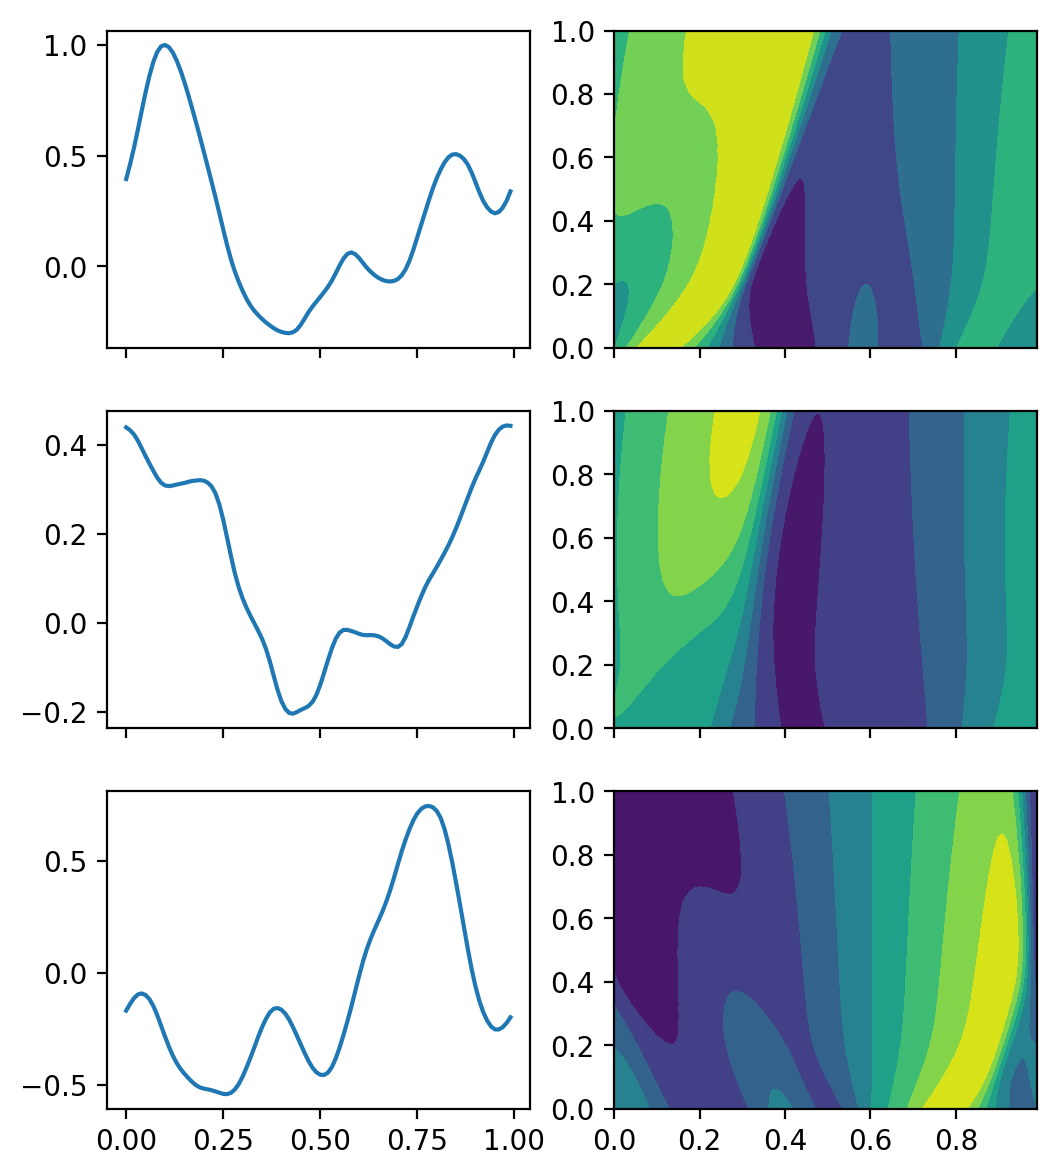

In [3]:
fig, ax = plt.subplots(3, 2, figsize=(6, 7), sharex='col')

key = random.PRNGKey(1117)
N_samples = 3
features, targets, coordinates = get_dataset_Burgers_2D(N_samples=N_samples, key=key, normalize=True)

for j in range(N_samples):
  ax[j, 0].plot(coordinates[0, 0], features[j, 0])

for j in range(N_samples):
  ax[j, 1].contourf(coordinates[0], coordinates[1]/jnp.max(coordinates[1]), targets[j, 0])

# Burgers D=1

In [4]:
def get_dataset_Burgers_1D(N_spatial=100, N_time=10000, time_subsampling=100, N_samples=1000, nu=0.01, key=random.PRNGKey(22), p=2, l=20, N=50, normalize=False):
    features, targets, coordinates = get_dataset_Burgers_2D(N_spatial=N_spatial, N_time=N_time, time_subsampling=time_subsampling, N_samples=N_samples, nu=nu, key=key, p=p, l=l, N=N, normalize=normalize)
    return features, targets[:, :, -1], coordinates[:1, 0]

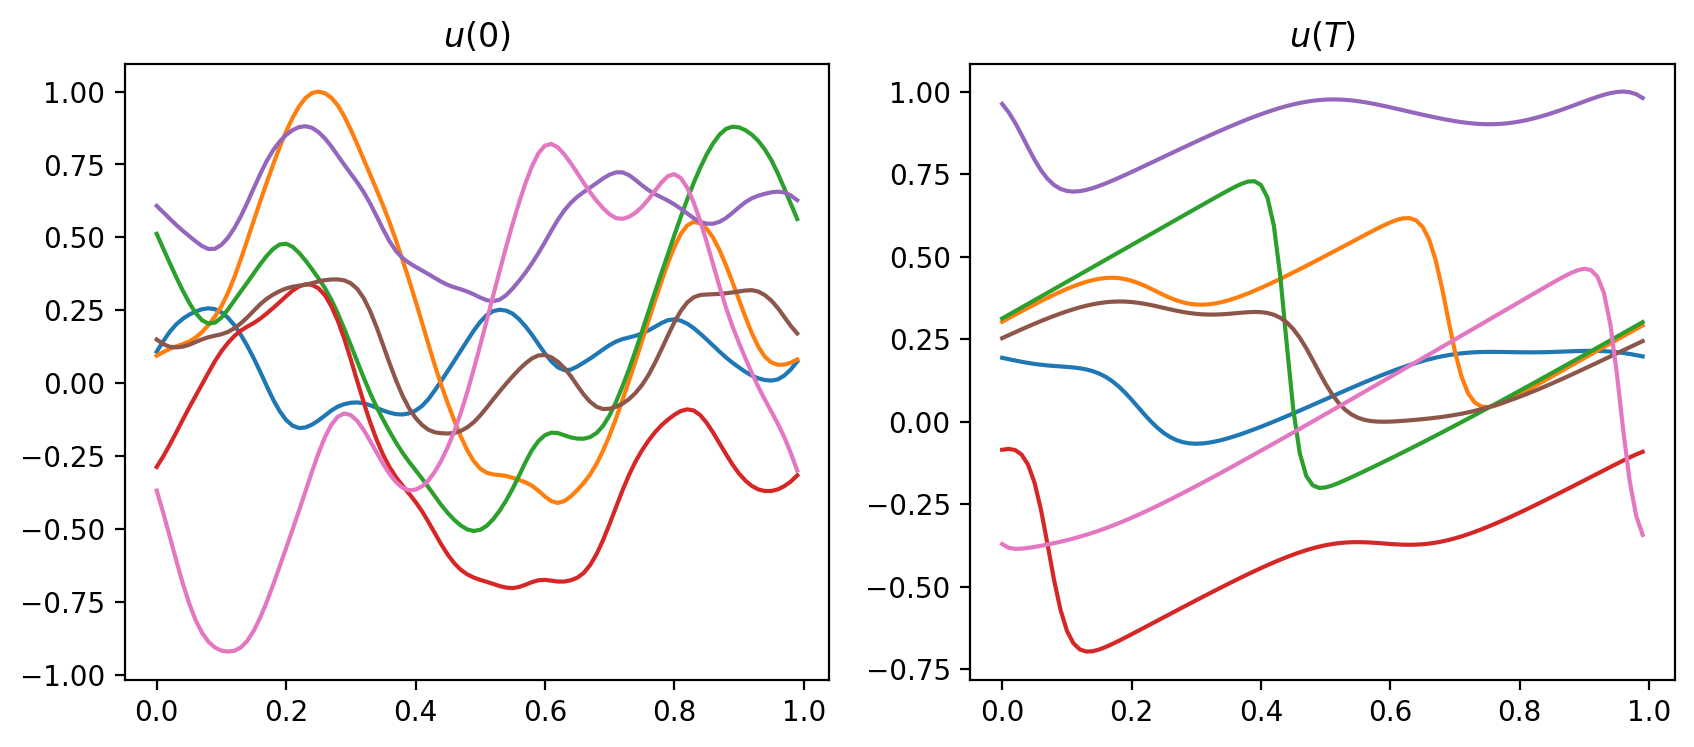

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
key = random.PRNGKey(11)
N_samples = 7
features, targets, coordinates = get_dataset_Burgers_1D(key=key, N_samples=N_samples, normalize=True)

for i, field in enumerate([features, targets]):
    for j in range(N_samples):
        ax[i].plot(coordinates[0], field[j, 0])

for i, n in enumerate(["$u(0)$", "$u(T)$"]):
    ax[i].set_title(n)